# Solutions - Practical Lesson 9

## Exercises

### Exercise 9.1
Given the historical series of two stock prices in the file $\href{https://repl.it/@MatteoSani/support9}{\textrm{historical_data.py}}$ compute the 5-day 95% VaR for a portfolio consisting of 100 shares of stock 1 and 50 shares of stock 2 (assume that last price of the series is today's price).

#### Solution 
We need to first generate the simulated scenarios rescaling today's market variables using the historical daily variations, then we can compute the $\Delta P$ distribution with the simulated portfolio values.

In [12]:
from historical_data import stock1, stock2
from matplotlib import pyplot as plt
import numpy as numpy

changes_s1 = []
changes_s2 = []

n = len(stock1)

for i in range(1, n-1):
    changes_s1.append(stock1[i]/stock1[i-1])

for i in range(1, n-1):
    changes_s2.append(stock2[i]/stock2[i-1])

a1 = 100
a2 = 50
p0 = a1*stock1[-1] + a2*stock2[-1]

delta_p = []
for i in range(n-2):
    p = a1 *stock1[-1]*changes_s1[i] + a2*stock2[-1]*changes_s2[i]
    delta_p.append(p - p0)

print () 
print ("1-day 5% percentile computed by numpy: {:.2f}"
       .format(numpy.percentile(numpy.array(delta_p), [5.0])[0]))
print ("5-day 5% percentile computed by numpy: {:.2f}"
       .format(numpy.percentile(numpy.array(delta_p), [5.0])[0]*numpy.sqrt(5)))

percentile = sorted(delta_p)
print ("5-day 5% percentile computed by hand: {:.2f}"
       .format(percentile[25]*numpy.sqrt(5)))


1-day 5% percentile computed by numpy: -232.97
5-day 5% percentile computed by numpy: -520.95
5-day 5% percentile computed by hand: -520.08


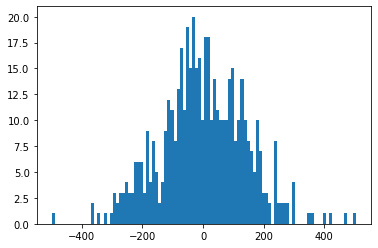

In [11]:
from matplotlib import pyplot as plt

plt.hist(delta_p, 100)
plt.show()

### Exrecise 9.2
Imagine a position consisting of 500000 EUR investemnt in FCA shares and a 750000 investiment in Apple shares. Assume that the daily volatilites of the two assets are 2.5% and 0.7% and that their correlation coefficient is 0.4.

What is tha 10-day 97.5% VaR for the portfolio ? 

#### Solution
You have to apply the proper formula derived in case of the gaussian daily returns. This can be done either by computing the summation by hand:

$$\begin{align*}\sigma^2_P & = \sum_{i=1}^{n}\sum_{j=1}^{n}\rho_{ij}a_i a_j \sigma_i \sigma_j \\
& = \sum_{i=1}^{n} a_i^2 \sigma_i^2 + 2 \sum_{i=1}^{n}\sum_{j<i}^{n}\rho_{ij}a_i a_j \sigma_i \sigma_j \end{align*}$$

or using the matrix notation and the `numpy` capabilities (which is much more scalable for when the number of assets increases):

$$\sigma^2_P = \begin{bmatrix}
    a_1 \sigma_n \\
    a_2 \sigma_n \\
    \vdots \\
    a_n \sigma_n
\end{bmatrix} 
\begin{bmatrix}
    \rho_{11} & \rho_{12} & \dots & \rho_{1n}\\
    \rho_{21} & \rho_{22} & \dots & \rho_{2n}\\
    \vdots \\
    \rho_{n1} & \rho_{n2} & \dots & \rho_{nn}
\end{bmatrix} 
\begin{bmatrix}
    a_1 \sigma_n & a_2 \sigma_n & \dots & a_n \sigma_n
\end{bmatrix} 
$$

In [2]:
import numpy
from scipy.stats import norm

a1 = .50
a2 = .75
sigma1 = 0.025
sigma2 = 0.007
rho = 0.4
ndays = 10

print ("Expliciting the summations")
print ()
sigma_p = numpy.sqrt((a1*sigma1)**2 + (a2*sigma2)**2 + 2*a1*a2*rho*sigma1*sigma2)
print ("10-day 97.5% VaR: {:.4f} M EUR".format(sigma_p*numpy.sqrt(ndays)*norm.ppf(0.025)))

# more scalable solution 
a = numpy.array([.50, 0.75])
sigma = numpy.array([0.025, 0.007])
rho = numpy.array([[1, 0.4],[0.4, 1]])

print ("With matrix computation")
sigma_p = numpy.sqrt((a * sigma).dot(rho.dot((a*sigma).T)))
print ("10-day 97.5% VaR: {:.4f} M EUR".format(sigma_p*numpy.sqrt(ndays)*norm.ppf(0.025)))


Expliciting the summations

10-day 97.5% VaR: -0.0953 M EUR
With matrix computation
10-day 97.5% VaR: -0.0953 M EUR


### Exrecise 9.3
Find today's price of a 4-years bond which pays semiannual coupons indexed with the LIBOR curve defined in $\href{https://repl.it/@MatteoSani/support9}{\textrm{curve_data.py}}$. The face value of the bond is 100000 EUR.

#### Solution
To price a bond we need to sum the future discounted cash flows and finally add the payment of the pricipal. From the technical point of view we need to create a `ForwardRateCurve` to compute the coupons and a `DiscountCurve` to get the discount factors.

In [3]:
from curve_data import discount_curve, libor_curve, pricing_date
from datetime import date
from dateutil.relativedelta import relativedelta

coupon_date = pricing_date
principal = 100000

price = 0
for i in range(8):
    coupon_date += relativedelta(months=6)
    price += principal * discount_curve.df(coupon_date) * \
             libor_curve.forward_rate(coupon_date)

price += principal * discount_curve.df(coupon_date)

print ("Today's bond price is {:.2f}".format(price))

Today's bond price is 109115.36


### Exrecise 9.4 (What we expect from your projects)
Given an arbitrary number of students and some project label write a python program which assigns randomly a project to the students. Assume you cannot assign the same project to more than one student or group.

The output should be a list of pairs student/project sorted alphabetically.

In [4]:
students = ["Pippo", "Pluto", "Paperino", "Banda Bassotti", "Qui, Quo e Qua"]
projects = ["Project {}".format(i) for i in range(7)]

#### Solution
Given the list of students I write a function that assign a random project keeping track of those already assigned to avoid duplication.

We set the random number generator seed to a known value in order to have reproducible results for debugging.

It is enough to define two lists (list of students/groups and list of projects), then looping on the students the program draws a random number to choose a project to be assigned.

In [5]:
import random
random.seed(1)

def assignProject(tmp_projects):
    return random.randint(0, len(tmp_projects))

I then iterate through the list of students assigning a project and removing that project from the list to not re-assign it. In the loop I also check that there are enough project for all the students.

I save the draw in a dictionary before printing it.

In [6]:
draw = {}

for s in students:
    if not projects: # this is equivalent to if len(projects) == 0
        print ("I'm sorry but there are not enough projects.")
        break
    project_n = assignProject(projects)
    draw[s] = projects[project_n]
    projects.remove(projects[project_n])

Finally I print the result with the students sorted alphabetically.

In [7]:
for d in sorted(draw.keys()):    
    print ("{} has to do {}".format(d, draw[d]))

Banda Bassotti has to do Project 4
Paperino has to do Project 0
Pippo has to do Project 2
Pluto has to do Project 5
Qui, Quo e Qua has to do Project 1
